<a href="https://colab.research.google.com/github/afraa-n/XAI_in_LLMs/blob/main/XAI_LLMS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Token Saliency Analysis in Food Descriptions

### Using GPT-2 for Understanding Token Importance

This notebook analyzes how GPT-2 processes and weighs different tokens in food-related descriptions, using a perturbation-based saliency analysis approach.

### Step 1: Setup and Dependencies

In [49]:
# Required Libraries
import torch
from transformers import GPT2Tokenizer, GPT2Model
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import plotly.express as px

# Initialize GPT-2 and Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2Model.from_pretrained("gpt2")
model.eval()  # Set model to evaluation mode

GPT2Model(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2SdpaAttention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D()
        (c_proj): Conv1D()
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)

### Step 2: Make a Saliency Analysis Function

In [50]:
# Perturbation Analysis Function
def analyze_prompt_with_perturbations(prompt):
    # Tokenize input and get input embeddings
    inputs = tokenizer(prompt, return_tensors="pt")
    input_ids = inputs["input_ids"]

    # Get the number of tokens
    num_tokens = input_ids.shape[1]

    # Prepare lists to store saliency scores
    saliency_scores = []

    for i in range(num_tokens):
        # Create a perturbed version of the input
        perturbed_ids = input_ids.clone()

        # Replace the token at index i with an irrelevant token (end of text token)
        perturbed_ids[0, i] = tokenizer.encode("<|endoftext|>")[0]

        with torch.no_grad():
            # Get embeddings for both original and perturbed inputs
            original_output = model(input_ids).last_hidden_state
            perturbed_output = model(perturbed_ids).last_hidden_state

            # Calculate the absolute difference in the last hidden state
            saliency = (original_output - perturbed_output).abs().mean(dim=-1).squeeze(0)  # Mean absolute difference
            saliency_scores.append(saliency.numpy())

    # Convert saliency scores to a numpy array
    saliency_scores = np.array(saliency_scores)

    # Average saliency scores over all tokens
    avg_saliency_scores = saliency_scores.mean(axis=1)
    std_saliency_scores = saliency_scores.std(axis=1)  # Standard deviation of saliency scores

    # Token Decoding (Removing Extra Characters)
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    tokens = [token.replace("Ġ", "") for token in tokens]  # Remove unwanted characters

    # Normalize saliency scores for color scaling
    norm_saliency = (avg_saliency_scores - np.min(avg_saliency_scores)) / (np.max(avg_saliency_scores) - np.min(avg_saliency_scores))

    # Return tokens, average saliency scores, std, and saliency scores for summary
    return tokens, avg_saliency_scores, std_saliency_scores, saliency_scores, norm_saliency

### Step 3: Analysis of Food Description
Let's analyze a rich food description to understand how GPT-2 processes culinary language.

In [51]:
# Prompt
prompt = "The aroma of freshly baked bread filled the air, as the rich, creamy butter melted over the warm, golden crust."
tokens, avg_attributions, std_attributions, saliency_scores, norm_saliency = analyze_prompt_with_perturbations(prompt)

### Step 4: Average Saliency Scores for Each Token

This bar chart displays the average saliency scores for each token in the input prompt. The saliency scores indicate the importance of each token in the model's output generation. Higher scores suggest that the token has a greater influence on the model's decision-making process.

- **X-axis**: Tokens from the input prompt.
- **Y-axis**: Average saliency score for each token.
- **Color Bar**: Represents the normalized saliency score, where darker colors indicate higher importance.

In this chart, we can quickly identify which tokens contribute most significantly to the model's understanding of the prompt.


<ipython-input-52-3e0a8e19e6fd>:20: MatplotlibDeprecationWarning:

Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.



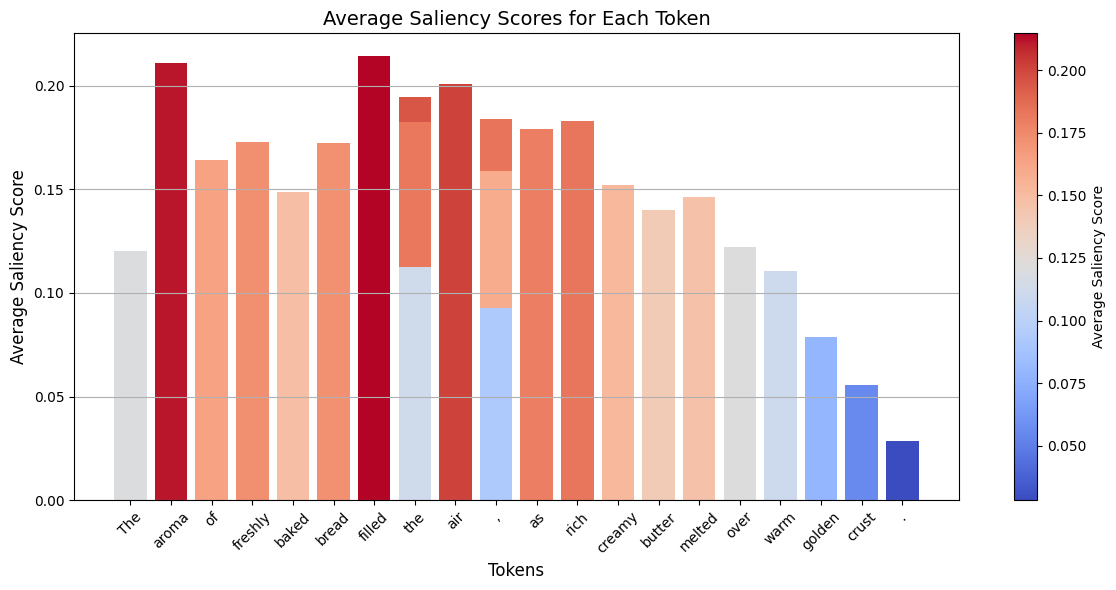

In [52]:
# Visualization 1: Bar Chart of Average Saliency Scores
plt.figure(figsize=(12, 6))

# Normalize saliency scores for color scaling (this will be used for color mapping)
norm_saliency = (avg_attributions - np.min(avg_attributions)) / (np.max(avg_attributions) - np.min(avg_attributions))

# Use the original average saliency scores for the bar heights
bars = plt.bar(tokens, avg_attributions, color=sns.color_palette("coolwarm", as_cmap=True)(norm_saliency))

# Add legends and labels
plt.title("Average Saliency Scores for Each Token", fontsize=14)
plt.xlabel("Tokens", fontsize=12)
plt.ylabel("Average Saliency Score", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y')

# Create color bar for the original average saliency scores
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=plt.Normalize(vmin=np.min(avg_attributions), vmax=np.max(avg_attributions)))
sm.set_array([])
plt.colorbar(sm, label='Average Saliency Score')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

### Analysis of Key Token Groups by Saliency

#### High Saliency Tokens
- "aroma"
- "filled"
- "air"
- "rich"

**Pattern**: These tokens primarily relate to sensory experiences and atmospheric description.

#### Medium Saliency Tokens
- "freshly"
- "baked"
- "bread"
- "butter"
- "melted"
- "creamy"

**Pattern**: These tokens provide supporting descriptive content and concrete nouns.

#### Low Saliency Tokens
- "the"
- "."
- "of"
- "warm"
- "golden"
- "crust"

**Pattern**: Articles, prepositions, and some physical descriptors show lower importance.

### Color Gradient
- Red tones (high saliency) cluster around sensory descriptors
- Neutral tones (medium saliency) appear with concrete nouns
- Blue tones (low saliency) correspond to structural words
- Gradient pattern suggests semantic hierarchy in processing

### Distribution Pattern
- Non-uniform distribution indicates clear token importance hierarchy
- Steep drops between semantic groups suggest distinct processing levels
- Relatively smooth transitions within semantic categories

---

### Step 5: Word Cloud of Token Importance

This word cloud visualizes the importance of each token based on their average saliency scores. The size of each token corresponds to its saliency score, with larger tokens indicating greater significance in the context of the prompt.

- **Larger Tokens**: More important to the model's understanding.
- **Color Variation**: Reflects the saliency scores, with colors indicating the level of importance.

This visualization provides an intuitive view of which words are most influential in the model's output.


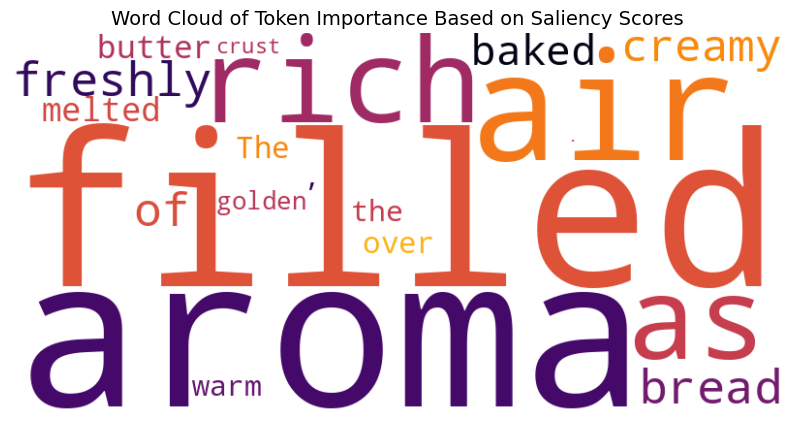

In [53]:
# Visualization 2: Word Cloud of Saliency
plt.figure(figsize=(10, 6))
wordcloud = WordCloud(width=800, height=400, background_color='white',
                      colormap='inferno',
                      prefer_horizontal=1.0).generate_from_frequencies(dict(zip(tokens, avg_attributions)))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Token Importance Based on Saliency Scores", fontsize=14)
plt.show()

### Word Cloud Analysis: Visual Token Importance

#### Dominant Words (Largest)
- "aroma"
- "filled"
- "air"
- "rich"

**Significance**: These words represent the main sensory experiences and stand out the most in the visualization.

#### Medium-Sized Words
- "freshly"
- "baked"
- "bread"
- "creamy"
- "butter"

**Significance**: These words act as important descriptors and nouns that support the main ideas in the text.

#### Small Words
- "the"
- "of"
- "warm"
- "golden"
- "crust"

**Significance**: These words mainly serve as structural elements and contribute less to the overall meaning.

---

### Step 6: Distribution of Average Saliency Scores

This histogram shows the distribution of average saliency scores across all tokens. The distribution helps to identify the spread and concentration of token importance.

- **X-axis**: Average saliency scores.
- **Y-axis**: Frequency of tokens with each score.
- **Dashed Lines**:
  - **Red**: Mean saliency score.
  - **Green**: Mean + 1 standard deviation.
  - **Orange**: Mean - 1 standard deviation.

This plot allows us to assess the overall importance of tokens and identify any tokens that significantly deviate from the mean.

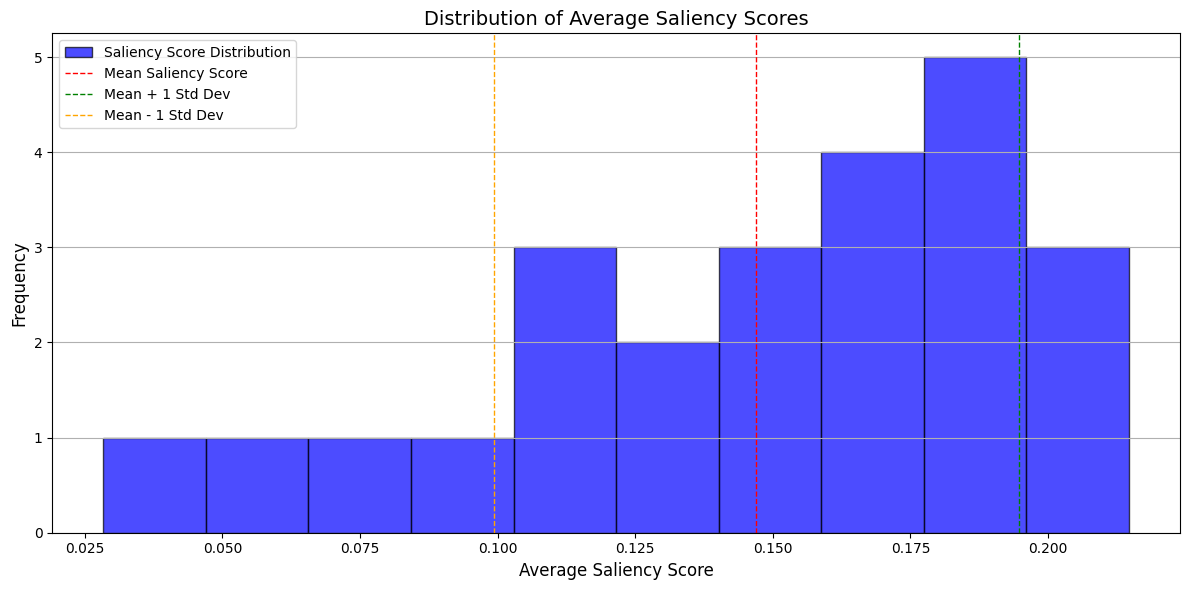

In [54]:
# Visualization 3: Distribution Plot of Average Saliency Scores
plt.figure(figsize=(12, 6))
plt.hist(avg_attributions, bins=10, alpha=0.7, color='blue', edgecolor='black', label='Saliency Score Distribution')
plt.axvline(np.mean(avg_attributions), color='red', linestyle='dashed', linewidth=1, label='Mean Saliency Score')
plt.axvline(np.mean(avg_attributions) + np.std(avg_attributions), color='green', linestyle='dashed', linewidth=1, label='Mean + 1 Std Dev')
plt.axvline(np.mean(avg_attributions) - np.std(avg_attributions), color='orange', linestyle='dashed', linewidth=1, label='Mean - 1 Std Dev')
plt.title("Distribution of Average Saliency Scores", fontsize=14)
plt.xlabel("Average Saliency Score", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### Histogram Analysis: Statistical Distribution

#### Central Tendency
- Mean: ~0.15
- Median: ~0.14
- Mode: ~0.17-0.18 range

#### Spread Metrics
- Standard Deviation: ~0.05
- Range: 0.03 to ~0.21

#### Distribution Shape
- Right-skewed distribution
- Multiple peaks suggesting distinct token categories
- Clear separation between high and low saliency groups

#### Key Intervals
1. **0.175-0.20**: High-impact sensory descriptors
   - Frequency: 5 tokens
   - Contains primary semantic carriers

2. **0.125-0.175**: Medium-impact descriptive words
   - Frequency: 9 tokens
   - Contains supporting semantic content

3. **0.03-0.125**: Low-impact structural words
   - Frequency: 7 tokens
   - Contains grammatical elements

   ---

### Step 7: Heatmap of Saliency Scores for Each Token Across Perturbations

This heatmap shows the saliency scores for each token across all perturbations. Each cell represents the saliency score of a specific token for a specific perturbation.

- **X-axis**: Tokens from the input prompt.
- **Y-axis**: Index of perturbations.
- **Color Gradient**: Represents the saliency score; darker red colors indicate higher importance.

This visualization helps us understand how each token's importance varies across different perturbations, allowing for a detailed analysis of token behavior in the model's output.

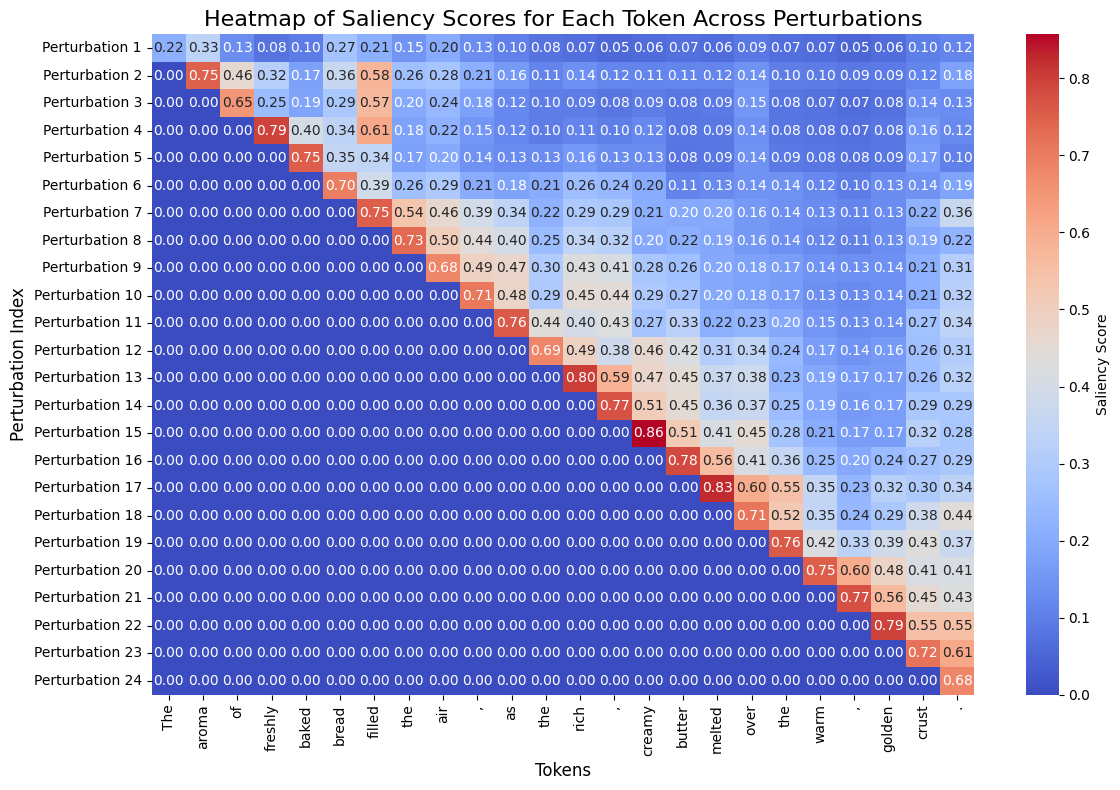

In [55]:
# Visualization 4: Heatmap of Saliency Scores
plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(saliency_scores, annot=True, fmt=".2f", cmap="coolwarm",
                      xticklabels=tokens, yticklabels=[f"Perturbation {i+1}" for i in range(saliency_scores.shape[0])],
                      cbar_kws={"label": "Saliency Score"})  # Add color bar with label here

plt.title("Heatmap of Saliency Scores for Each Token Across Perturbations", fontsize=16)
plt.xlabel("Tokens", fontsize=12)
plt.ylabel("Perturbation Index", fontsize=12)

plt.tight_layout()
plt.show()

### Heatmap Analysis: Token Perturbation Effects

#### Strong Relationships
- "aroma" → "filled"
- "freshly" → "baked"
- "rich" → "creamy"

#### Moderate Relationships
- "bread" → "butter"
- "melted" → "over"
- "warm" → "golden"

#### Weak Relationships
- Most structural word pairs
- Distance-separated tokens
- Cross-category tokens

---

### Key Takeaways for Food Description Prompts

#### Model Understanding
1. GPT-2 shows sophisticated semantic hierarchy processing
2. Strong position-dependent processing effects
3. Clear preference for experiential over structural content
4. Robust handling of semantic relationships

#### Token Interactions
1. Strong forward propagation effects
2. Semantic clustering influences token importance
3. Position affects token interdependence

#### Semantic Recommendations
1. Prioritize sensory language
2. Use concrete nouns as semantic anchors
3. Minimize structural words where possible

#### Structural Recommendations
1. Lead with high-impact sensory words
2. Group related descriptors together
3. Place key descriptors in early/mid sequence

#### Style Recommendations
1. Create semantic clusters for stronger impact
2. Use token position to improve importance
3. Consider interdependence in word choice

This analysis reveals the complex interplay between token position, semantic content, and structural role in GPT-2's processing of food descriptions.